## Imports & Loading the Dataset

Importing necessary libraries, getting big picture of what the data looks like, 

### 📊 Full Metadata Field Descriptions (SLICE-3D)

#### ✅ Target Column (train-metadata.csv only)
- **target**: Binary label. `1` = malignant, `0` = benign. This is the prediction target.

#### 🆔 Identifiers
- **isic_id**: Unique identifier for each image.
- **patient_id**: Unique identifier for each patient.
- **lesion_id**: Unique ID for manually tagged lesions of interest (some lesions only).
- **image_name**: Filename of the image (in the image directory).

---

#### 👤 Demographic Features
- **age_approx**: Approximate age of the patient at time of imaging.
- **sex**: Biological sex (`male`, `female`, `unknown`).
- **anatom_site_general**: High-level body location of the lesion (e.g. `torso`, `lower extremity`).
- **tbp_lv_location**: Granular body location (e.g., `upper_arm`, `lower_leg`, etc.).
- **tbp_lv_location_simple**: Simplified version of the body location.

---

#### 🧬 Diagnosis Fields (train only)
- **iddx_full**, **iddx_1** to **iddx_5**: Hierarchical diagnosis levels from detailed to general.
- **mel_thick_mm**: Depth of melanoma invasion (in mm), only for malignant melanomas.
- **mel_mitotic_index**: Mitotic index for melanoma.

---

#### 📷 Image Context Fields
- **image_type**: Type of image (e.g., TBP).
- **tbp_tile_type**: Lighting modality (e.g., cross-polarized, non-polarized).
- **attribution**: Source institution for the image.
- **copyright_license**: Licensing info.

---

#### 📐 Lesion Geometry Features
- **clin_size_long_diam_mm**: Maximum diameter (mm).
- **tbp_lv_areaMM2**: Lesion area in mm².
- **tbp_lv_perimeterMM**: Lesion perimeter in mm.
- **tbp_lv_minorAxisMM**: Smallest diameter of lesion in mm.
- **tbp_lv_area_perim_ratio**: Border jaggedness — perimeter-to-area ratio.

---

#### 🎨 Color Metrics (LAB color space + other)
- **tbp_lv_L**, **tbp_lv_Lext**: Lightness inside and outside the lesion.
- **tbp_lv_A**, **tbp_lv_Aex**: Red-green color channel inside/outside lesion.
- **tbp_lv_B**, **tbp_lv_Bext**: Yellow-blue channel inside/outside.
- **tbp_lv_H**, **tbp_lv_Hext**: Hue inside/outside lesion.
- **tbp_lv_color_std_mean**: Color irregularity — std. dev. of color inside lesion.
- **tbp_lv_stdL**, **tbp_lv_stdLExt**: Std. dev. of L channel inside/outside.
- **tbp_lv_radial_color_std_max**: Asymmetry in color distribution.
- **tbp_lv_deltaL**, **tbp_lv_deltaA**, **tbp_lv_deltaB**: Contrast between inside and outside of lesion for each channel.
- **tbp_lv_deltaLBnorm**: Overall contrast of lesion vs. skin (important for visual detectability).

---

#### 🔲 Symmetry + Border Shape Features
- **tbp_lv_norm_border**: Normalized border irregularity (0–10).
- **tbp_lv_norm_color**: Normalized color variation (0–10).
- **tbp_lv_symm_2axis**: Border asymmetry score (0 = symmetrical, 10 = highly asymmetrical).
- **tbp_lv_symm_2axis_angle**: Angle of symmetry axis.
- **tbp_lv_eccentricity**: Measure of lesion elongation (0 = circle, 1 = elongated).

---

#### 🤖 Neural Network Confidence Scores
- **tbp_lv_dnn_lesion_confidence**: Model-derived lesion detection confidence (0–100).
- **tbp_lv_nevi_confidence**: CNN-derived nevus likelihood (0–100), trained on 57k dermatologist-labeled lesions.

---

#### 🗺️ 3D TBP Positioning
- **tbp_lv_x**, **tbp_lv_y**, **tbp_lv_z**: Lesion coordinates in 3D total body capture.

---

### 🧼 Tip:
Many of these fields can be highly correlated or sparse depending on the lesion. It’s good practice to:
- Analyze null values (`df.isnull().sum()`)
- Visualize distributions
- Use model-based feature selection or SHAP to identify the most predictive ones.


In [1]:
# imports

#NOTE: Check cross validation to make sure model doesn't SEE the training data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedGroupKFold # stratified kfold for class imbalance
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, confusion_matrix


In [2]:
# display settings

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
train_df = pd.read_csv("train-metadata.csv")
test_df = pd.read_csv("test-metadata.csv")

/tmp/ipykernel_111/1941375984.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("train-metadata.csv")


In [4]:
train_df.info() 
train_df.describe()
train_df['target'].value_counts(normalize=True) # counts how many benign (0) and malignant (1) samples.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

target
0    0.99902
1    0.00098
Name: proportion, dtype: float64

## Exploratory Data Analysis

Extreme class imbalance. Especially in medical diagnosis, the important part is reducing false negatives.

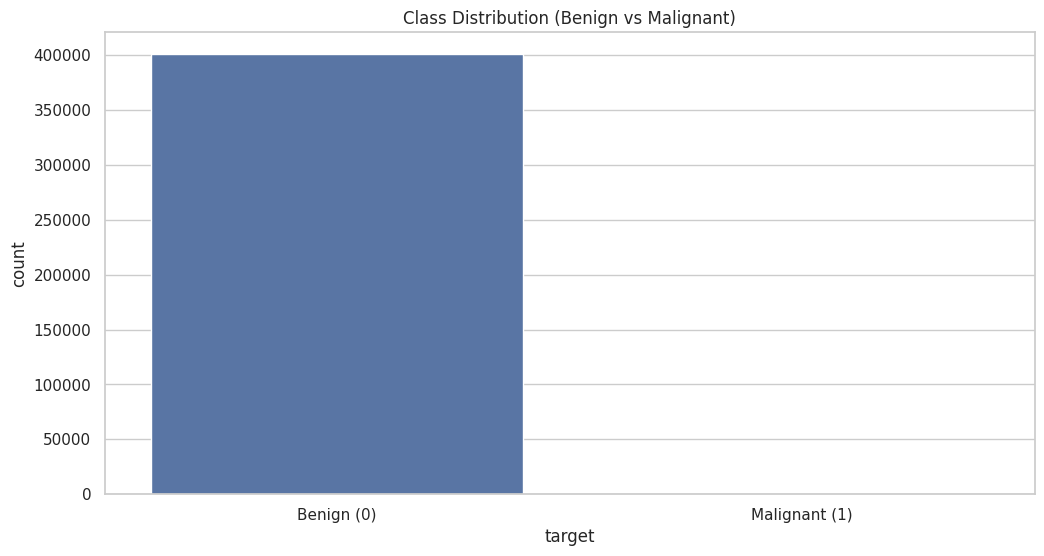

target
0    99.902009
1     0.097991
Name: proportion, dtype: float64


In [5]:
# Class Imbalance
sns.countplot(x='target', data=train_df)
plt.title('Class Distribution (Benign vs Malignant)')
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'])
plt.show()

# Show percentages
print(train_df['target'].value_counts(normalize=True) * 100)

/tmp/ipykernel_111/1726827570.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sex_stats, x='Sex', y='Malignancy_Rate', palette='coolwarm')


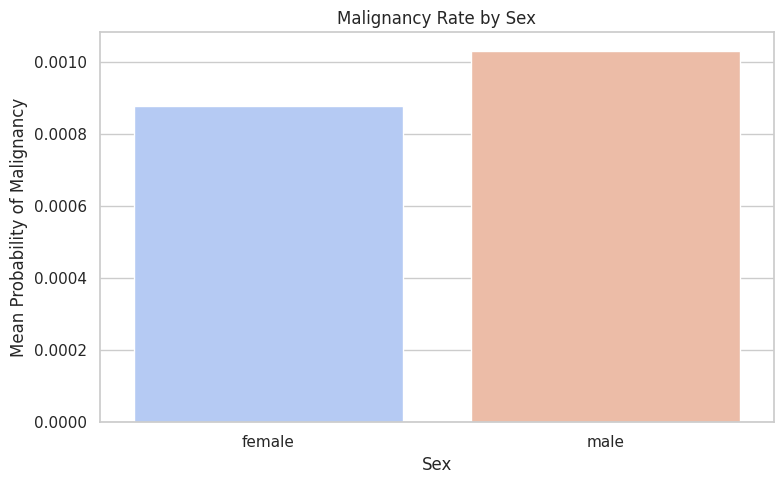

In [6]:
# Calculate malignancy rate
sex_stats = train_df.groupby('sex')['target'].agg(['count', 'mean']).reset_index()
sex_stats.columns = ['Sex', 'Sample_Count', 'Malignancy_Rate']

# Barplot
plt.figure(figsize=(8, 5))
sns.barplot(data=sex_stats, x='Sex', y='Malignancy_Rate', palette='coolwarm')
plt.title('Malignancy Rate by Sex')
plt.ylabel('Mean Probability of Malignancy')
plt.xlabel('Sex')
plt.tight_layout()
plt.show()

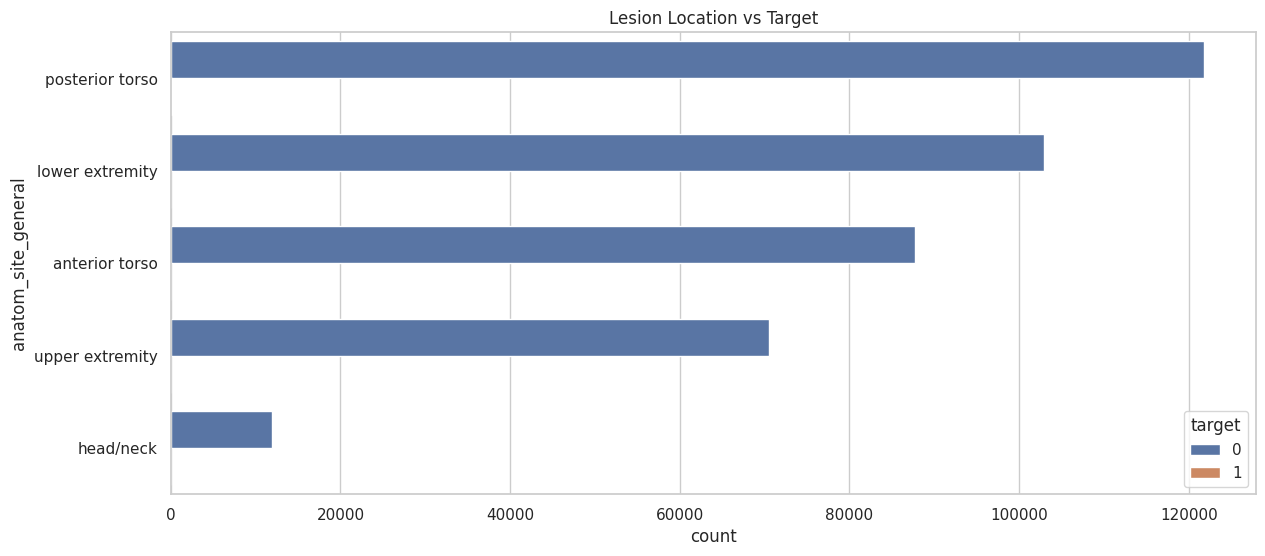

In [7]:
plt.figure(figsize=(14, 6))
sns.countplot(data=train_df, y='anatom_site_general', hue='target', order=train_df['anatom_site_general'].value_counts().index)
plt.title('Lesion Location vs Target')
plt.show()

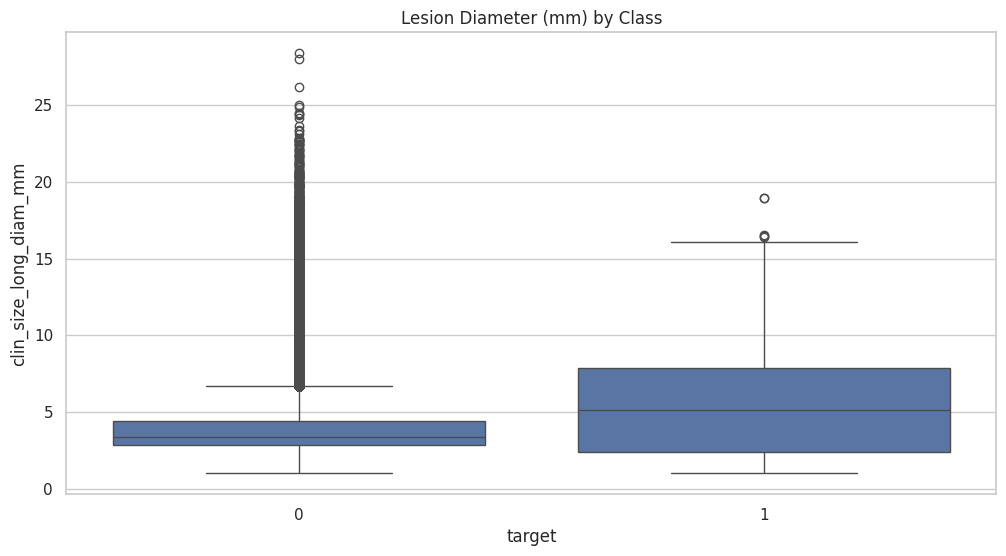

In [8]:
sns.boxplot(data=train_df, x='target', y='clin_size_long_diam_mm')
plt.title('Lesion Diameter (mm) by Class')
plt.show()

#Takeaways from boxplot: On Average, the malignant lesions are larger in size than the benign ones. 
#However, there are significant outlieres in the benign class. Many large lesions exist within the benign class

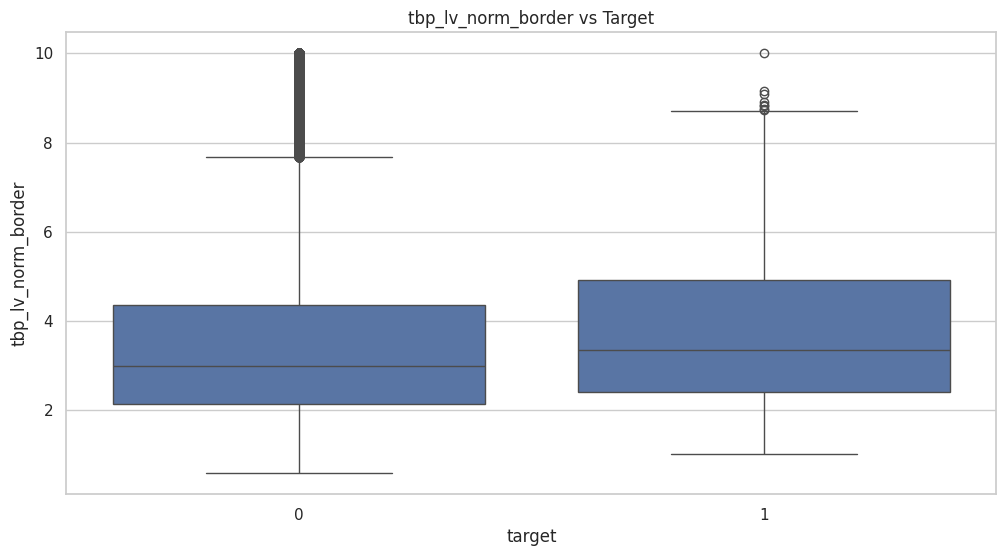

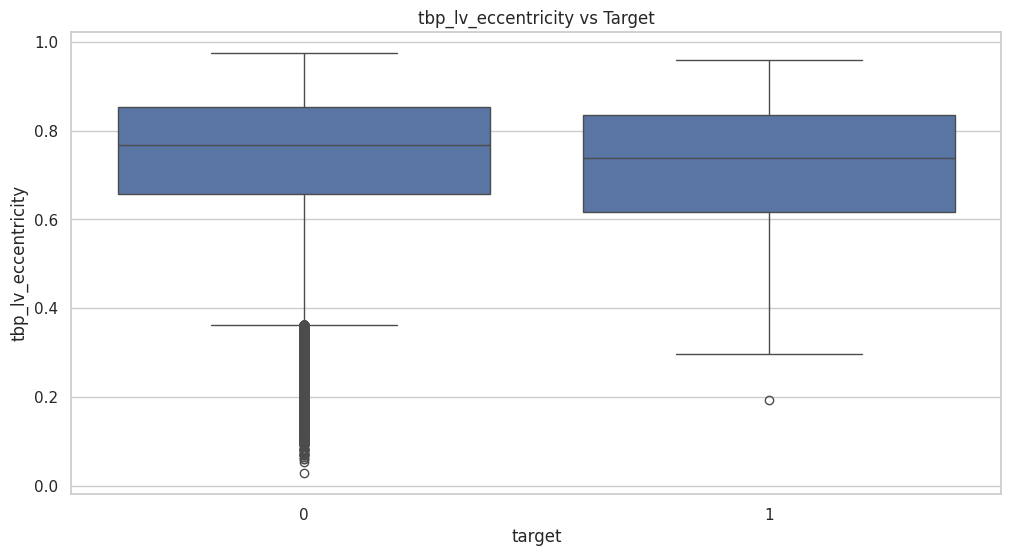

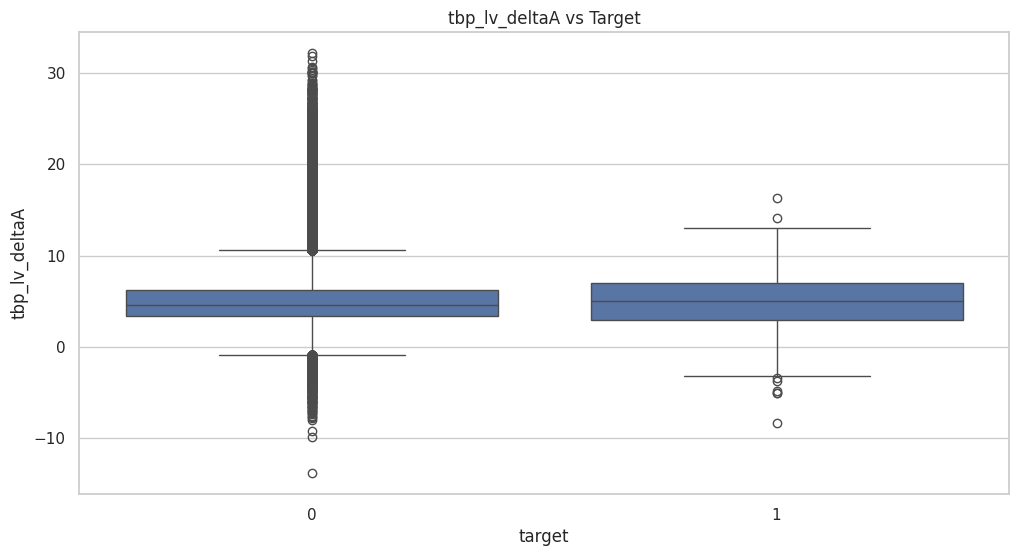

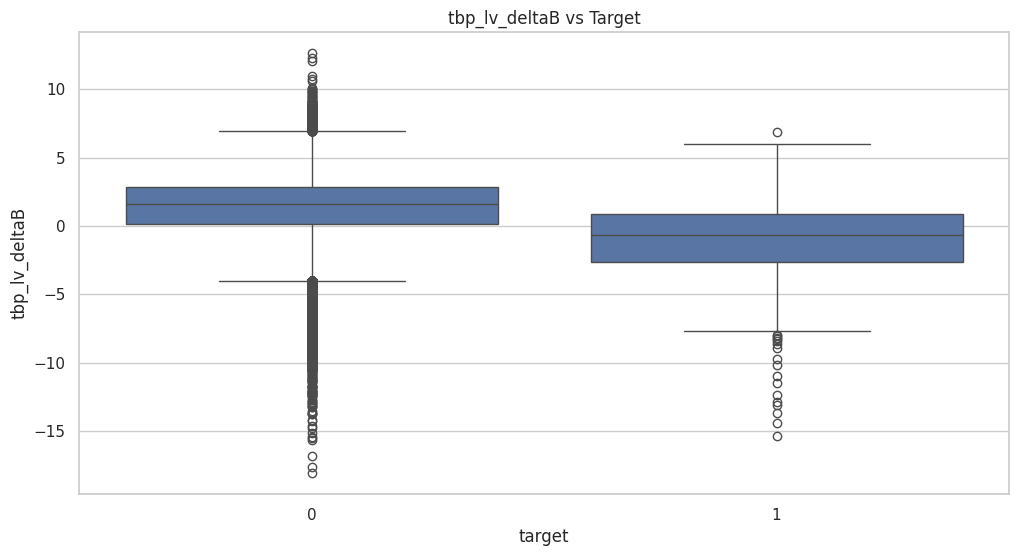

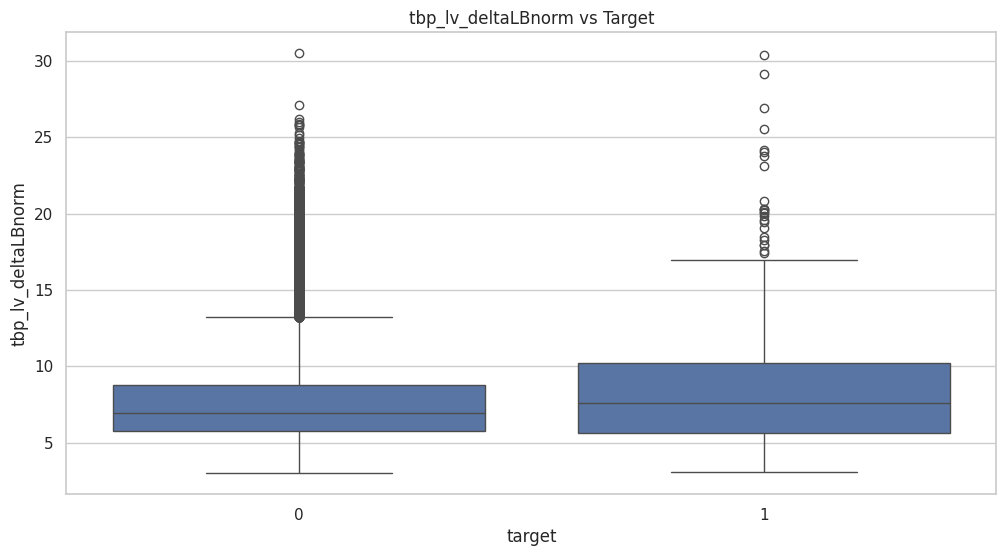

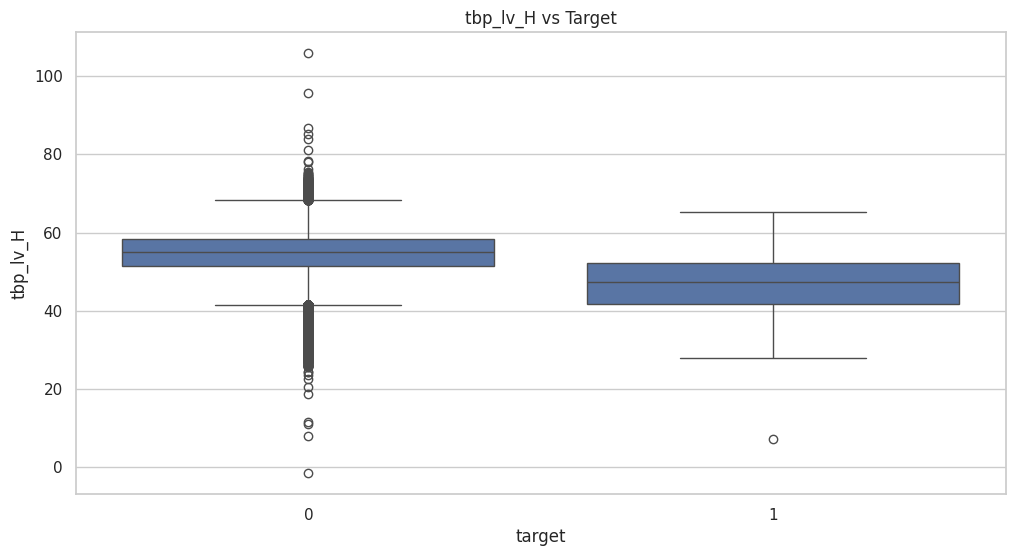

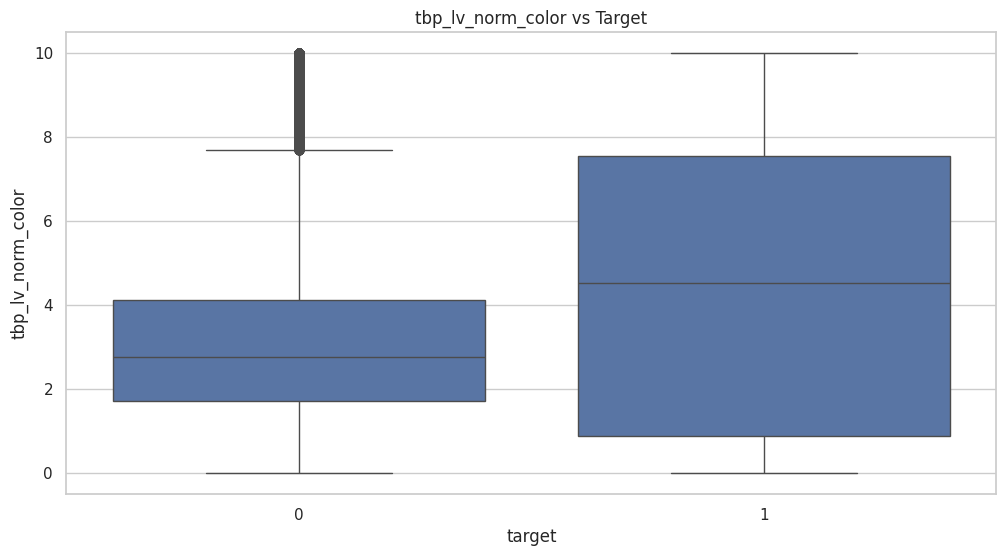

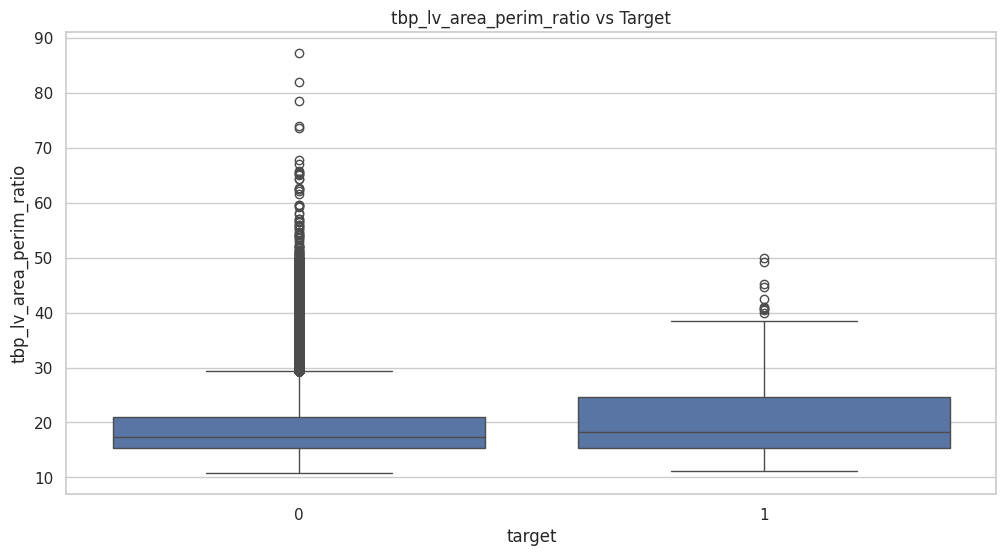

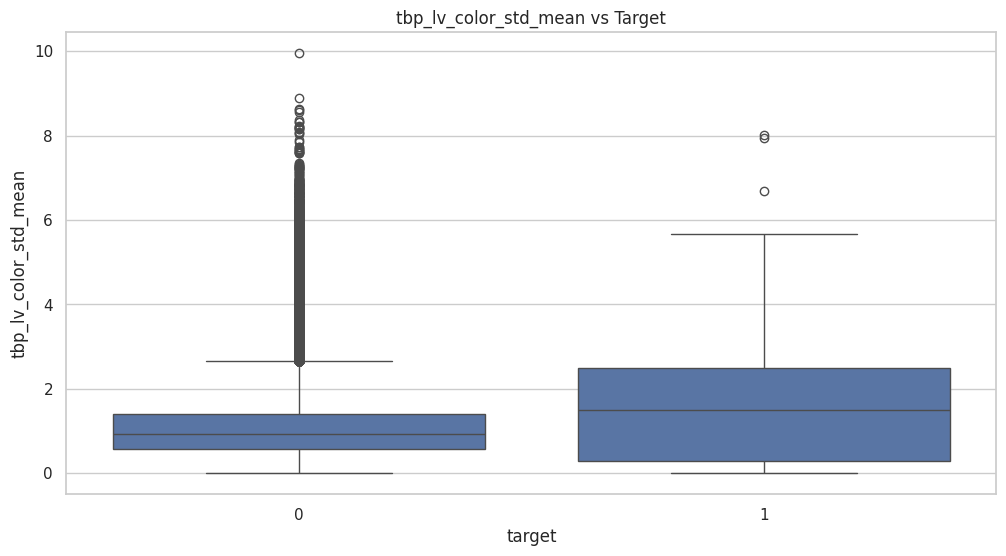

In [9]:
# Color and Border Features

features = ['tbp_lv_norm_border', 'tbp_lv_eccentricity', 'tbp_lv_deltaA', 'tbp_lv_deltaB','tbp_lv_deltaLBnorm','tbp_lv_H', 'tbp_lv_norm_color', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean']

for feature in features:
    sns.boxplot(data=train_df, x='target', y=feature)
    plt.title(f'{feature} vs Target')
    plt.show()

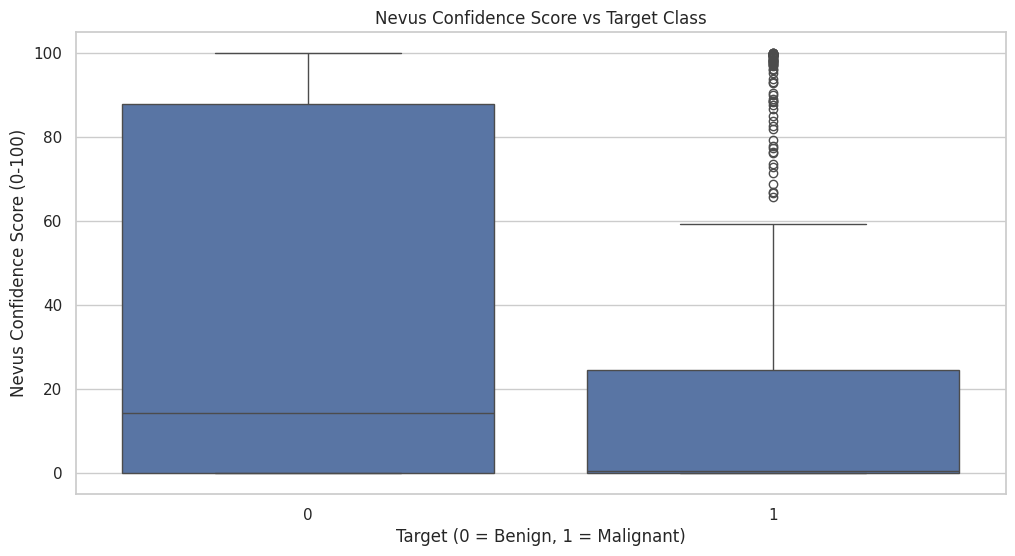

In [10]:
sns.boxplot(data=train_df, x='target', y='tbp_lv_nevi_confidence')
plt.title('Nevus Confidence Score vs Target Class')
plt.xlabel('Target (0 = Benign, 1 = Malignant)')
plt.ylabel('Nevus Confidence Score (0-100)')
plt.show()

/tmp/ipykernel_111/322377827.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=location_stats, x='Malignancy_Rate', y='Location', palette='coolwarm')


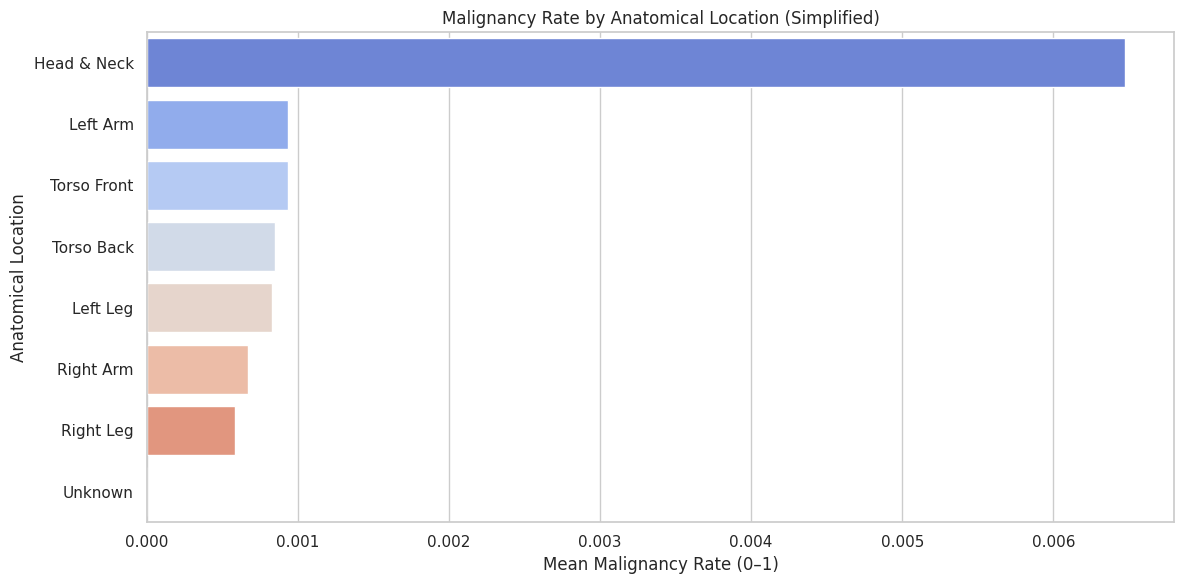

In [11]:
# Group by simplified location and calculate malignancy rate
location_stats = train_df.groupby('tbp_lv_location_simple')['target'].agg(['count', 'mean']).reset_index()
location_stats.columns = ['Location', 'Sample_Count', 'Malignancy_Rate']

# Sort locations by malignancy rate
location_stats = location_stats.sort_values('Malignancy_Rate', ascending=False)

# Plot barplot of malignancy rate
plt.figure(figsize=(12, 6))
sns.barplot(data=location_stats, x='Malignancy_Rate', y='Location', palette='coolwarm')
plt.title('Malignancy Rate by Anatomical Location (Simplified)')
plt.xlabel('Mean Malignancy Rate (0–1)')
plt.ylabel('Anatomical Location')
plt.tight_layout()
plt.show()

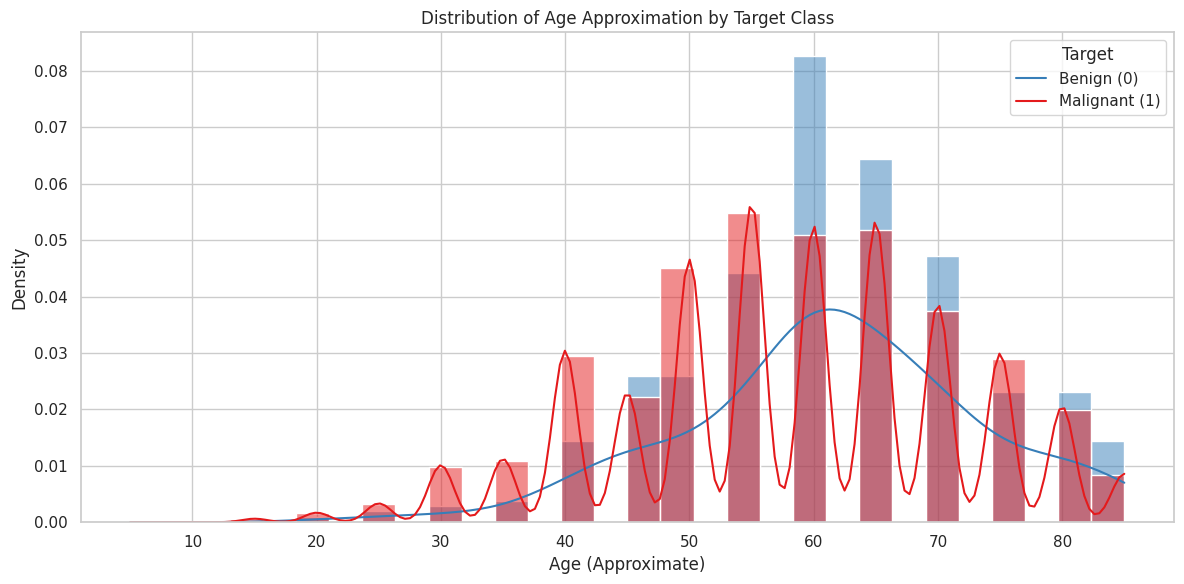

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='age_approx', hue='target', bins=30, kde=True, stat='density', palette='Set1', common_norm=False)
plt.title('Distribution of Age Approximation by Target Class')
plt.xlabel('Age (Approximate)')
plt.ylabel('Density')
plt.legend(title='Target', labels=['Benign (0)', 'Malignant (1)'])
plt.tight_layout()
plt.show()

## Feature Engineering & Preprocessing for XGBoost

In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

In [14]:
#understanding nulls
def null_summary(df):
    null_counts = df.isnull().sum()
    null_pct = 100 * null_counts / len(df)
    return pd.DataFrame({
        "Missing Values": null_counts,
        "Percent (%)": null_pct.round(2)
    }).sort_values(by="Missing Values", ascending=False)

print("Train Null Summary:")
print(null_summary(train_df))

print("\nTest Null Summary:")
print(null_summary(test_df))


Train Null Summary:
                              Missing Values  Percent (%)
iddx_5                                401058       100.00
mel_mitotic_index                     401006        99.99
mel_thick_mm                          400996        99.98
iddx_4                                400508        99.86
iddx_3                                399994        99.73
iddx_2                                399991        99.73
lesion_id                             379001        94.50
sex                                    11517         2.87
anatom_site_general                     5756         1.44
age_approx                              2798         0.70
tbp_lv_norm_color                          0         0.00
tbp_lv_stdL                                0         0.00
tbp_lv_radial_color_std_max                0         0.00
tbp_lv_perimeterMM                         0         0.00
isic_id                                    0         0.00
tbp_lv_norm_border                         0        

In [15]:
# Drop high-missing or ID columns
drop_cols = [ 'image_name', 'lesion_id',
    'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5',
    'mel_thick_mm', 'mel_mitotic_index', 'copyright_license', 'image_type', 'tbp_tile_type',
    'tbp_tile_x', 'tbp_tile_y', 'tbp_tile_z', 'attribution', 'iddx_full', 'iddx_1'

]
train_df.drop(columns=drop_cols, errors='ignore', inplace=True)

# Fill missing categorical values with 'unknown'
train_df['sex'].fillna('unknown', inplace=True)
train_df['anatom_site_general'].fillna('unknown', inplace=True)

# Label encode categorical columns
for col in ['sex', 'anatom_site_general', 'tbp_lv_location', 'tbp_lv_location_simple']:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str))

# Fill age_approx with median
train_df['age_approx'].fillna(train_df['age_approx'].median(), inplace=True)

# Define features and target
X = train_df.drop(columns=['target'])
y = train_df['target']




In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 42 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    401059 non-null  float64
 4   sex                           401059 non-null  int64  
 5   anatom_site_general           401059 non-null  int64  
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   tbp_lv_A                      401059 non-null  float64
 8   tbp_lv_Aext                   401059 non-null  float64
 9   tbp_lv_B                      401059 non-null  float64
 10  tbp_lv_Bext                   401059 non-null  float64
 11  tbp_lv_C                      401059 non-null  float64
 12  tbp_lv_Cext                   401059 non-nul

## Split into Training & Validation Sets

In [17]:
X = train_df.drop(columns=['target', 'isic_id', 'patient_id'])  # keep patient_id separately
y = train_df['target']
groups = train_df['patient_id']

cv = StratifiedGroupKFold(n_splits=5)
for train_idx, val_idx in cv.split(X, y, groups):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    break  # just use the first fold

## Feature Selection

In [18]:
#Train a model to measure feature importance
model = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

#Use SelectFromModel to pick features above the median importance threshold

selector = SelectFromModel(model, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)

# Get the names of selected features
selected_feature_names = X_train.columns[selector.get_support()].tolist()
print("Selected Features:", selected_feature_names)

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:56:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Selected Features: ['clin_size_long_diam_mm', 'tbp_lv_C', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_color_std_mean', 'tbp_lv_deltaB', 'tbp_lv_deltaLBnorm', 'tbp_lv_location', 'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color', 'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_y', 'tbp_lv_z', 'tbp_lv_dnn_lesion_confidence']
/root/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/root/venv/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


## Model Training

In [19]:
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1000,
    use_label_encoder=False,
    eval_metric='aucpr',
    random_state=42
)

model.fit(
    X_train_selected, y_train,
    eval_set=[(X_val_selected, y_val)],
    verbose=True
)


[0]	validation_0-aucpr:0.03449
[1]	validation_0-aucpr:0.04407
[2]	validation_0-aucpr:0.04032
[3]	validation_0-aucpr:0.02523
[4]	validation_0-aucpr:0.02538
[5]	validation_0-aucpr:0.02768
[6]	validation_0-aucpr:0.02823
/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [21:56:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[7]	validation_0-aucpr:0.02857
[8]	validation_0-aucpr:0.02752
[9]	validation_0-aucpr:0.04115
[10]	validation_0-aucpr:0.04328
[11]	validation_0-aucpr:0.04105
[12]	validation_0-aucpr:0.04112
[13]	validation_0-aucpr:0.04192
[14]	validation_0-aucpr:0.04409
[15]	validation_0-aucpr:0.04469
[16]	validation_0-aucpr:0.04079
[17]	validation_0-aucpr:0.04436
[18]	validation_0-aucpr:0.04475
[19]	validation_0-aucpr:0.05031
[20]	validation_0-aucpr:0.05017
[21]	validation_0-aucpr:0.05111
[22]	validation_0-aucpr:0.05355
[23]	validation_0-aucpr:0.05502
[24]	validation_0

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

## Model Evaluation

In [20]:
y_pred_proba = model.predict_proba(X_val_selected)[:, 1]
print("ROC AUC:", roc_auc_score(y_val, y_pred_proba))
print("PR AUC:", average_precision_score(y_val, y_pred_proba))

ROC AUC: 0.9549856263485934
PR AUC: 0.09825872348411242


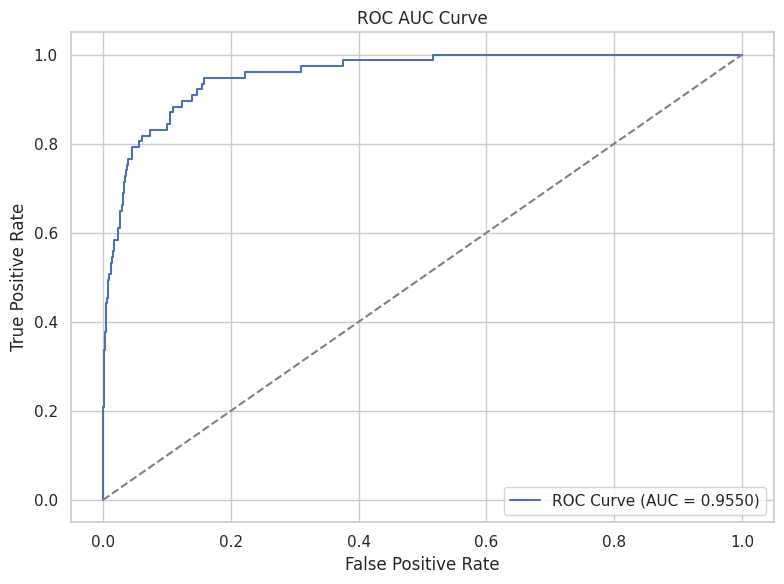

In [21]:
# Get false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_val, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

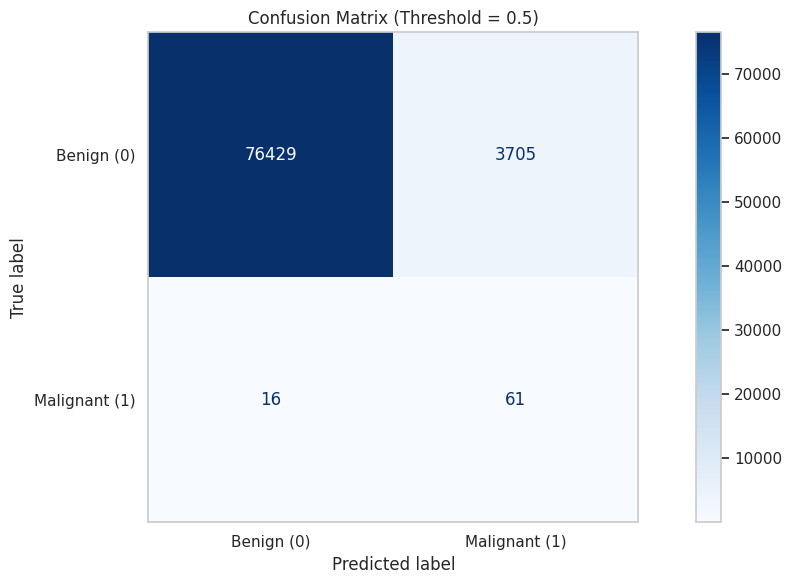

In [22]:
# Default threshold: 0.5
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred_binary)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign (0)', 'Malignant (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Threshold = 0.5)')
plt.grid(False)
plt.tight_layout()
plt.show()


In [23]:
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")


Confusion Matrix:
[[76429  3705]
 [   16    61]]
True Negatives:  76429
False Positives: 3705
False Negatives: 16
True Positives:  61


## Threshold Adjusting

In medical diagnoses, a false negative is much much worse than a false positive. Thus, we will lower the threshold to catch more malignant cases.

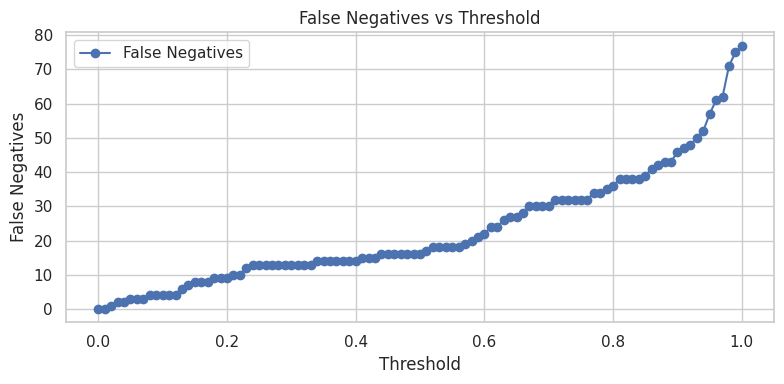

Threshold  FN    FP    TP    TN    FPR (%)  
0.00       0     80134 77    0     100.00
0.01       0     52343 77    27791 65.32
0.02       1     37312 76    42822 46.56
0.03       2     29838 75    50296 37.24
0.04       2     25246 75    54888 31.50
0.05       3     22130 74    58004 27.62
0.06       3     19828 74    60306 24.74
0.07       3     18004 74    62130 22.47
0.08       4     16617 73    63517 20.74
0.09       4     15398 73    64736 19.22
0.10       4     14388 73    65746 17.95
0.11       4     13577 73    66557 16.94
0.12       4     12813 73    67321 15.99
0.13       6     12160 71    67974 15.17
0.14       7     11582 70    68552 14.45
0.15       8     11060 69    69074 13.80
0.16       8     10586 69    69548 13.21
0.17       8     10184 69    69950 12.71
0.18       9     9777  68    70357 12.20
0.19       9     9395  68    70739 11.72
0.20       9     9071  68    71063 11.32
0.21       10    8743  67    71391 10.91
0.22       10    8468  67    71666 10.57
0.23       

In [24]:
# Find the best threshold that minimizes FN while also keeping an acceptable False Positive rate

thresholds = np.arange(0.0, 1.01, 0.01)
results = []

for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    results.append((t, tn, fp, fn, tp, fpr))

threshold_vals = [r[0] for r in results]
false_negatives = [r[3] for r in results]  # updated index because of added fpr

plt.figure(figsize=(8, 4))
plt.plot(threshold_vals, false_negatives, marker='o', label='False Negatives')
plt.xlabel("Threshold")
plt.ylabel("False Negatives")
plt.title("False Negatives vs Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Sort by: FN ascending, then threshold ascending
sorted_results = sorted(results, key=lambda x: (x[3], x[0]))  # x[3]=FN, x[0]=threshold

print(f"{'Threshold':<10} {'FN':<5} {'FP':<5} {'TP':<5} {'TN':<5} {'FPR (%)':<9}")
for t, tn, fp, fn, tp, fpr in sorted_results:
    print(f"{t:<10.2f} {fn:<5} {fp:<5} {tp:<5} {tn:<5} {fpr*100:<.2f}")


We have a higher rate of false positives, but this is desirable in industry. This is essentially saying "this lesion might be malignant - let a dermatologist decide." We chose a threshold of 0.12 given its balance between an industry-acceptable FPR (16%) and low FN rate, 5.2% 

/root/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:03:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
Validation Confusion Matrix @ threshold 0.12:
[[67321 12813]
 [    4    73]]
TP: 73, TN: 67321, FP: 12813, FN: 4
False Negative Rate (FNR): 5.19%


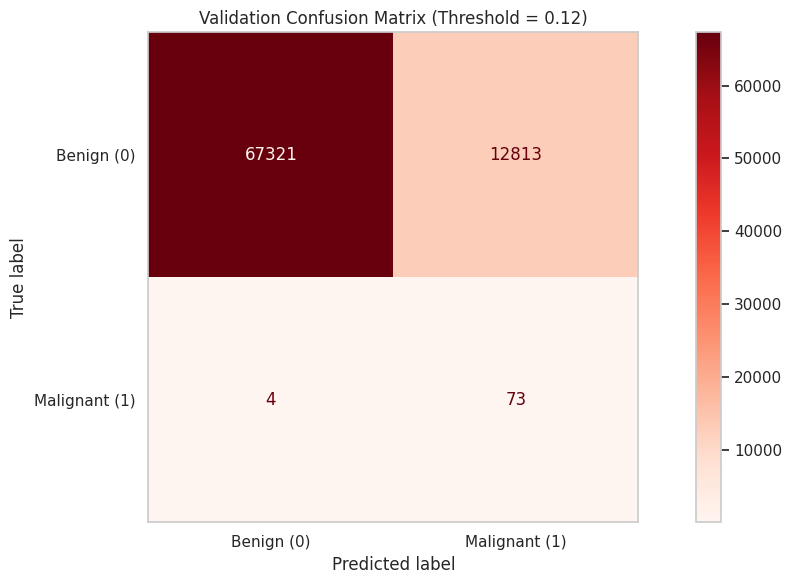

In [32]:
# Train final model on selected training features
final_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1000,
    use_label_encoder=False,
    eval_metric='aucpr',
    random_state=42
)

final_model.fit(X_train_selected, y_train)

# --------------------------
# ✅ VALIDATION EVALUATION
# --------------------------

# Predict probabilities on validation set
y_val_proba = final_model.predict_proba(X_val_selected)[:, 1]

# Apply threshold
threshold = 0.12
y_val_pred = (y_val_proba >= threshold).astype(int)

# Confusion matrix
cm_val = confusion_matrix(y_val, y_val_pred)
tn, fp, fn, tp = cm_val.ravel()
fnr = fn / (fn + tp)

# Print results
print(f"Validation Confusion Matrix @ threshold {threshold}:\n{cm_val}")
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
print(f"False Negative Rate (FNR): {fnr:.2%}")

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=['Benign (0)', 'Malignant (1)'])
disp.plot(cmap='Reds', values_format='d')
plt.title(f'Validation Confusion Matrix (Threshold = {threshold})')
plt.grid(False)
plt.tight_layout()
plt.show()




## Feature Importance & Iteration

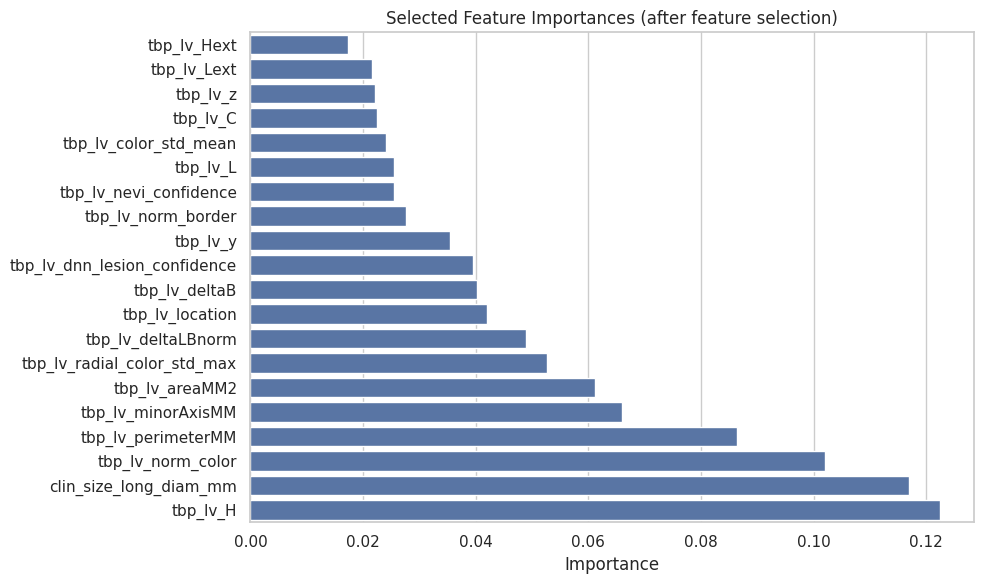

In [34]:
# Use the selected feature names from the SelectFromModel step
importance = model.feature_importances_
feat_names = X_train.columns[selector.get_support()]  # only selected features

# Sort by importance (optional but helpful for visualization)
sorted_idx = np.argsort(importance)
sorted_feat_names = np.array(feat_names)[sorted_idx]
sorted_importance = importance[sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importance, y=sorted_feat_names)
plt.title('Selected Feature Importances (after feature selection)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [36]:
Expl# --------------------------
# ✅ TEST PREDICTION (No ground truth as the targets are hidden_ 
# --------------------------

# --- ✅ STEP 1: Prepare test features (must match training setup) ---

X_test = test_df.drop(columns=['isic_id', 'patient_id'], errors='ignore')  # mimic your X = train_df.drop(...)

# Fill missing values (match train_df preprocessing)
X_test['sex'].fillna('unknown', inplace=True)
X_test['anatom_site_general'].fillna('unknown', inplace=True)
X_test['age_approx'].fillna(train_df['age_approx'].median(), inplace=True)

# Encode categoricals with same mapping as training
for col in ['sex', 'anatom_site_general']:
    le = LabelEncoder()
    le.fit(train_df[col].astype(str))  # fit on training values only
    X_test[col] = le.transform(X_test[col].astype(str))

# --- ✅ STEP 2: Apply the trained selector ---
X_test_selected = selector.transform(X_test)

# --- ✅ STEP 3: Predict probabilities with trained model ---
test_proba = final_model.predict_proba(X_test_selected)[:, 1]

# --- ✅ STEP 4: Apply your new threshold ---
threshold = 0.12  # or whatever new threshold you're using
test_pred = (test_proba >= threshold).astype(int)

# --- ✅ STEP 5: Create final output ---
submission_df = test_df[['isic_id']].copy()
submission_df['predicted_probability'] = test_proba
submission_df['predicted_label'] = test_pred

# Show preview
print(submission_df.head())

# Optional: Save as CSV
# submission_df.to_csv("final_submission.csv", index=False)


ValueError: y contains previously unseen labels: 'male'

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5aa2dff2-e96c-4cb0-b8ad-bd02825c7bef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>